# Set keys

In [1]:
from dotenv import load_dotenv
import os
load_dotenv()
os.environ['LANGSMITH_API_KEY'] = os.getenv('LANGSMITH_API_KEY')
os.environ['TAVILY_API_KEY'] = os.getenv('TAVILY_API_KEY')
os.environ['GROQ_API_KEY'] = os.getenv('GROQ_API_KEY')
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGSMITH_PROJECT"] = "chatbot"

# Part 1 : Basic Chatbot
We'll first create a simple chatbot using LangGraph.

## StateGraph
we can cosider the state graph as the blueprint of the chatbot.

In [2]:
# Import Annotated type for adding metadata to type hints
from typing import Annotated
# Import TypedDict for creating structured dictionary types with type hints
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
# Import message handling utility for state updates
from langgraph.graph.message import add_messages

# Define the graph's state structure using TypedDict
class State(TypedDict):
    # Messages state key uses Annotated to specify update behavior:
    # - Stores chat messages as a list
    # - add_messages specifies messages should be appended (not overwritten)
    messages: Annotated[list, add_messages]

# Initialize a state graph with our defined State structure
# This will manage the flow of messages through the graph
graph_builder = StateGraph(State)

Our graph can now handle two key tasks:

1. Each node can receive the current State as input and output an update to the state.
2. Updates to messages will be appended to the existing list rather than overwriting it, thanks to the prebuilt add_messages function used with the Annotated syntax.

In [3]:
from langchain_groq import ChatGroq

llm = ChatGroq(
    model="mixtral-8x7b-32768",
    temperature=0.0,
    max_retries=2,
)


def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

![alt text](images/chatBot.drawio.png)

Next, add an entry point. This tells our graph where to start its work each time we run it.

In [4]:
graph_builder.add_edge(START, "chatbot")

![alt text](images/start&chatbot.drawio.png)

Similarly, set a finish point. This instructs the graph "any time this node is run, you can exit."

In [5]:
graph_builder.add_edge("chatbot", END)

![alt text](images/fullchart.drawio.png)

call "compile()" on the graph builder. This creates a "CompiledGraph" we can use invoke on our state.

In [6]:
graph = graph_builder.compile()

visualize the graph

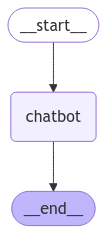

In [7]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

## Run the ChatBot
Tip: You can exit the chat loop at any time by typing "quit", "exit", or "q".

In [8]:
def stream_graph_updates(user_input: str):
    """
    Streams updates from the LangGraph by processing user input and printing the assistant's responses.

    Args:
        user_input (str): The input provided by the user to be processed by the graph.

    Output:
        Prints the assistant's response to the console for each update from the graph.
    """
    # Stream updates from the graph by passing the user input as a message
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        # Iterate through the values in the event (e.g., messages, state updates)
        for value in event.values():
            # Print the latest message from the assistant
            print("Assistant:", value["messages"][-1].content)


# Main loop for user interaction
while True:
    try:
        # Prompt the user for input
        user_input = input("User: ")
        # Check if the user wants to quit the conversation
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            # Exit the loop and end the program
            break

        # Process the user input and stream updates from the graph
        print("User: " + user_input)
        stream_graph_updates(user_input)
    except:
        # Fallback in case input() is unavailable (e.g., in non-interactive environments)
        user_input = "What do you know about OpenAI?"
        # Print the fallback user input
        print("User: " + user_input)
        # Process the fallback input and stream updates from the graph
        stream_graph_updates(user_input)
        # Exit the loop after processing the fallback input
        break
    print("-"*100)

User: hi
Assistant: Hello! How can I help you today? If you have any questions or need assistance with

* General knowledge questions
* Explanations of concepts
* Writing assistance
* Code examples
* Math problems
* Language translations
* Or anything else, just let me know! I'm here to help.
----------------------------------------------------------------------------------------------------
User: hi
Assistant: Hello! How can I help you today? If you have any questions or need assistance with

* General knowledge questions
* Explanations of concepts
* Writing assistance
* Code examples
* Math problems
* Language translations
* Or anything else, just let me know! I'm here to help.
----------------------------------------------------------------------------------------------------
User: hi
Assistant: Hello! How can I help you today? If you have any questions or need assistance with

* General knowledge questions
* Explanations of concepts
* Writing assistance
* Code examples
* Math probl

However, you may have noticed that the bot's knowledge is limited to what's in its training data. In the next part, we'll add a web search tool to expand the bot's knowledge and make it more capable

# Part 2 : Enhancing the Chatbot with Tools

In [9]:
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=2) # two respnse will be provided from the search results
tools = [tool] # adding tool to list of tools
tool.invoke("What is the time at New Delhi, India?") # Web search

[{'url': 'https://time.is/New_Delhi',
  'content': 'Time.is Time in New Delhi, National Capital Territory of Delhi, India now Sun: ↑ 07:03AM ↓ 06:08PM (11h 5m) - More info - Make New Delhi time default - Add to favorite locations Time zone info for New Delhi The time in New Delhi is 10 hours and 30 minutes ahead of the time in United States when United States is on standard time, and 9 hours and 30 minutes ahead of the time in United States when United States is on daylight saving time. New Delhi has not had daylight saving time since 1945. The IANA time zone identifier for New Delhi is Asia/Kolkata. Sunrise, sunset, day length and solar time for New Delhi The current local time in New Delhi is 35 minutes ahead of apparent solar time. Time here&there What time is it?'},
 {'url': 'https://www.worldtimebuddy.com/india-new-delhi',
  'content': "Time in New Delhi, India - World Time Buddy 630 pm GMT 730 pm GMT 830 pm GMT New Delhi TimeUse the above converter to visually and very quickly co

The results are page summaries our chat bot can use to answer questions.

we can add bind_tools on our LLM. This lets the LLM know the correct JSON format to use if it wants to use our search engine.

In [10]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_groq import ChatGroq

class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


llm = ChatGroq(model="qwen-2.5-32b")
# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

Next we need to create a function to actually run the tools if they are called. We'll do this by adding the tools to a new node.

Below, we implement a BasicToolNode that checks the most recent message in the state and calls tools if the message contains tool_calls. It relies on the LLM's tool_calling support, which is available in Anthropic, OpenAI, Google Gemini, and a number of other LLM providers.

We will later replace this with LangGraph's prebuilt ToolNode.

Check here to see the LLM list with tool calling ability: [langchain_page](https://python.langchain.com/docs/integrations/chat/?ref=blog.langchain.dev#featured-providers).

In [11]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

Conditional edges usually contain "if" statements to route to different nodes depending on the current graph state. These functions receive the current graph state and return a string or list of strings indicating which node(s) to call next.

In [12]:
def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

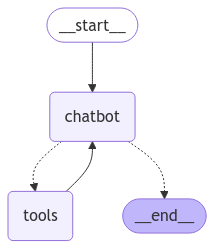

In [13]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [14]:
while True:
    try:
        user_input = input("User: ")
        print("User: " + user_input)
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User: q
Goodbye!


In [15]:
from typing import Annotated

from langchain_groq import ChatGroq
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatGroq(
    model="gemma2-9b-it",
    temperature=0.0,
    max_retries=2,
)
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool]) # Defining the tools, so that it's visible for the LLM
graph_builder.add_node("tools", tool_node)

# Add a condition inbetween the tool and the chatbot, then by default the chatbot is connected to end
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step, no condition required
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")
graph = graph_builder.compile()

In [16]:
# help(StateGraph)

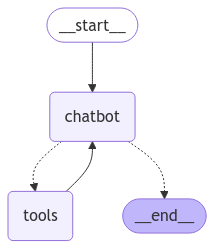

In [17]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [18]:
while True:
    try:
        user_input = input("User: ")
        print("User: " + user_input)
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User: q
Goodbye!


# Part 3: Adding Memory to the Chatbot

If you provide a checkpointer when compiling the graph and a thread_id when calling your graph, LangGraph automatically saves the state after each step. When you invoke the graph again using the same thread_id, the graph loads its saved state, allowing the chatbot to pick up where it left off.

We will see later that checkpointing is much more powerful than simple chat memory - it lets you save and resume complex state at any time for error recovery, human-in-the-loop workflows, time travel interactions, and more.

In [19]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [20]:
from typing import Annotated

from langchain_groq import ChatGroq
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatGroq(model="qwen-2.5-32b")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

In [21]:
graph = graph_builder.compile(checkpointer=memory)

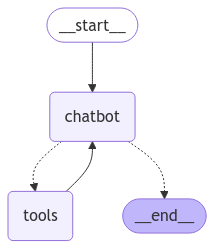

In [22]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [23]:
# Pick a thread to use as the key for this conversation.
config = {"configurable": {"thread_id": "1"}}

In [24]:
user_input = "Hi there! My name is Will."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Will.
================================== Ai Message ==================================

Hello, Will! Nice to meet you. How can I assist you today?


In [25]:
user_input = "Remember my name?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

Yes, I remember your name is Will. How can I assist you further?


In [26]:
# The only difference is we change the `thread_id` here to "2" instead of "1"
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    {"configurable": {"thread_id": "2"}},
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

Of course! You're the user I've been assisting. Could you remind me of your name though? I want to make sure I have it right.


what goes into a checkpoint? To inspect a graph's state for a given config at any time, call get_state(config).

In [27]:
snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='Hi there! My name is Will.', additional_kwargs={}, response_metadata={}, id='88e4e33e-25d7-4e66-ad0a-6802d5542515'), AIMessage(content='Hello, Will! Nice to meet you. How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 209, 'total_tokens': 226, 'completion_time': 0.042874707, 'prompt_time': 0.012063304, 'queue_time': 0.233732219, 'total_time': 0.054938011}, 'model_name': 'qwen-2.5-32b', 'system_fingerprint': 'fp_35f92f8282', 'finish_reason': 'stop', 'logprobs': None}, id='run-fe779f99-d306-485e-bd08-b0ced0bd6edc-0', usage_metadata={'input_tokens': 209, 'output_tokens': 17, 'total_tokens': 226}), HumanMessage(content='Remember my name?', additional_kwargs={}, response_metadata={}, id='a1ec2af5-2b84-49dc-b37c-187b7b16e4da'), AIMessage(content='Yes, I remember your name is Will. How can I assist you further?', additional_kwargs={}, response_metadata={'token

# Part 4: Human-in-the-loop

LangGraph's persistence layer supports human-in-the-loop workflows, allowing execution to pause and resume based on user feedback. The primary interface to this functionality is the interrupt function. Calling interrupt inside a node will pause execution. Execution can be resumed, together with new input from a human, by passing in a Command. interrupt is ergonomically similar to Python's built-in input(), with some caveats. 

In [28]:
from typing import Annotated

from langchain_groq import ChatGroq
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

from langgraph.types import Command, interrupt


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

# human in loop
@tool
def human_assistance(query: str) -> str:
    """Request assistance from a human."""
    human_response = interrupt({"query": query})
    return human_response["data"]


tool = TavilySearchResults(max_results=2)
tools = [tool, human_assistance]
llm = ChatGroq(model="qwen-2.5-32b")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    # Because we will be interrupting during tool execution,
    # we disable parallel tool calling to avoid repeating any
    # tool invocations when we resume.
    assert len(message.tool_calls) <= 1
    return {"messages": [message]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

In [29]:
memory = MemorySaver()

graph = graph_builder.compile(checkpointer=memory)

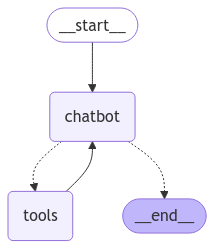

In [30]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

Let's now prompt the chatbot with a question that will engage the new human_assistance tool:

In [31]:
user_input = "I need some expert guidance for building an AI agent. Could you request assistance for me?"
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert guidance for building an AI agent. Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  human_assistance (call_9ft7)
 Call ID: call_9ft7
  Args:
    query: I need some expert guidance for building an AI agent.


The chatbot generated a tool call, but then execution has been interrupted! Note that if we inspect the graph state, we see that it stopped at the tools node:

In [32]:
snapshot = graph.get_state(config)
snapshot.next # the next state is tool calling

('tools',)

Similar to Python's built-in input() function, calling interrupt inside the tool will pause execution. Progress is persisted based on our choice of checkpointer-- so if we are persisting with Postgres, we can resume at any time as long as the database is alive. Here we are persisting with the in-memory checkpointer, so we can resume any time as long as our Python kernel is running.

To resume execution, we pass a Command object containing data expected by the tool. The format of this data can be customized based on our needs. Here, we just need a dict with a key "data":

In [33]:
human_response = (
    "We, the experts are here to help! We'd recommend you check out LangGraph to build your agent."
    " It's much more reliable and extensible than simple autonomous agents."
)

human_command = Command(resume={"data": human_response})

events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  human_assistance (call_9ft7)
 Call ID: call_9ft7
  Args:
    query: I need some expert guidance for building an AI agent.
================================= Tool Message =================================
Name: human_assistance

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autonomous agents.
================================== Ai Message ==================================

We have expert advice for you! They recommend checking out LangGraph for building your AI agent. It's noted to be more reliable and extensible compared to simpler autonomous agents. This could be a great starting point for your project!


# Part 5: Customizing State

In [34]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]
    name: str
    birthday: str

In [35]:
from langchain_core.messages import ToolMessage
from langchain_core.tools import InjectedToolCallId, tool

from langgraph.types import Command, interrupt


@tool
# Note that because we are generating a ToolMessage for a state update, we
# generally require the ID of the corresponding tool call. We can use
# LangChain's InjectedToolCallId to signal that this argument should not
# be revealed to the model in the tool's schema.
def human_assistance(
    name: str, birthday: str, tool_call_id: Annotated[str, InjectedToolCallId]
) -> str:
    """Request assistance from a human."""
    human_response = interrupt(
        {
            "question": "Is this correct?",
            "name": name,
            "birthday": birthday,
        },
    )
    # If the information is correct, update the state as-is.
    if human_response.get("correct", "").lower().startswith("y"):
        verified_name = name
        verified_birthday = birthday
        response = "Correct"
    # Otherwise, receive information from the human reviewer.
    else:
        verified_name = human_response.get("name", name)
        verified_birthday = human_response.get("birthday", birthday)
        response = f"Made a correction: {human_response}"

    # This time we explicitly update the state with a ToolMessage inside
    # the tool.
    state_update = {
        "name": verified_name,
        "birthday": verified_birthday,
        "messages": [ToolMessage(response, tool_call_id=tool_call_id)],
    }
    # We return a Command object in the tool to update our state.
    return Command(update=state_update)

In [37]:
from langchain_groq import ChatGroq
from langchain_community.tools.tavily_search import TavilySearchResults

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition


tool = TavilySearchResults(max_results=2)
tools = [tool, human_assistance]
llm = ChatGroq(model="qwen-2.5-32b")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    assert len(message.tool_calls) <= 1
    return {"messages": [message]}


graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

In [38]:
user_input = (
    "Can you look up when LangGraph was released? "
    "When you have the answer, use the human_assistance tool for review."
)
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Can you look up when LangGraph was released? When you have the answer, use the human_assistance tool for review.
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_3dhk)
 Call ID: call_3dhk
  Args:
    query: LangGraph release date
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://pypi.org/project/langgraph/", "content": "LangGraph is a library for building stateful, multi-actor applications with LLMs, used to create agent and multi-agent workflows. The simplest way to create a tool-calling agent in LangGraph is to use create_react_agent: # Define the tools for the agent to use # Define the tools for the agent to use # This means that after `tools` is called, `agent` node is called next. workflow.add_edge(\"tools\", 'agent') Normal edge: after the 

BadRequestError: Error code: 400 - {'error': {'message': "Failed to call a function. Please adjust your prompt. See 'failed_generation' for more details.", 'type': 'invalid_request_error', 'code': 'tool_use_failed', 'failed_generation': 'It appears there was a mistake in the search results as the release date provided (Feb 6, 2025) is in the future and the search result does not directly state the release date of LangGraph. Let\'s request human assistance to verify this information since the data provided is not reliable.\n<tool_call>\n{"name": "human_assistance", "arguments": "{\\"name\\": \\"LangGraph Release Date Inquiry\\", \\"birthday\\": \\"None\\"}"}\n</tool_call>'}}

In [ ]:
human_command = Command(
    resume={
        "name": "LangGraph",
        "birthday": "Jan 17, 2024",
    },
)

events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()